In [ ]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import seaborn as sns
from scipy.stats import norm
import nltk
nltk.download('punkt')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Get data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load training and test data
recipes = pd.read_json('/content/drive/MyDrive/Grad School-Files/Coding/Kaggle Cooking/train.json')
test = pd.read_json('/content/drive/MyDrive/Grad School-Files/Coding/Kaggle Cooking/test.json')

In [ ]:
#Examine training data head
recipes.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [ ]:
#Check for null values
print(recipes.isnull().values.any())

False


In [ ]:
#Examine test data head
test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [ ]:
#Check for test data null values
print(test.isnull().values.any())

False


In [ ]:
#Examine training data shape and datatypes
print(recipes.shape)
print(recipes.info())

(39774, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None


In [ ]:
#Check the unique cuisine categories
recipes['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


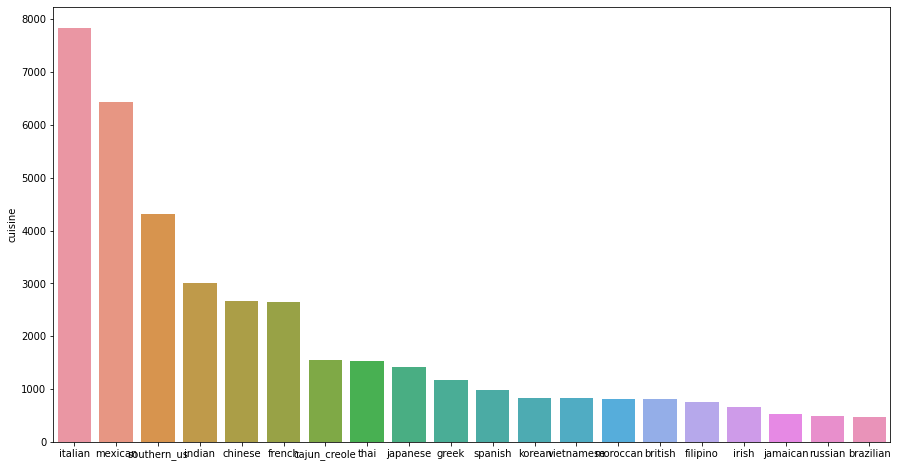

In [ ]:
#What are the top 10 cuisines in the dataset
top10cuisines = recipes['cuisine'].value_counts()
plot_dims = (15,8)
fig, ax = plt.subplots(figsize = plot_dims)
sns.barplot(x=top10cuisines.index, y=top10cuisines)
print(recipes['cuisine'].value_counts())

In [ ]:
#Set the 'labels' for classification
y = recipes['cuisine']

#Start processing features
ing = recipes['ingredients']
ing = [' '.join(s) for s in ing]

So realistically,  since the ingredients don't have any punction or stopwords, so we don't really have to process the features for that, but we'll do it anyway. 

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def preproc(ing):

  STOPWORDS = set(stopwords.words('english'))
  ing = ing.apply(lambda ing: ' '.join(ing)) # convert list of ingredients to string
  ing = ing.str.lower() # ingredients string to lower case letters
  ing = ing.apply(lambda ing: ' '.join([word for word in ing.split() if word not in STOPWORDS])) # remove stopwords       
        
  return ing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ing = preproc(recipes['ingredients'])
ing_test = preproc(test['ingredients'])

## Train-validation split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(ing, y, test_size=0.33, random_state=42)

## Setting Up Pipelines

In [ ]:
#Check which model works best

pipelines = {}

NB_Pipeline = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())
              ])
pipelines['NB'] = NB_Pipeline

LR_Pipeline = Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', LogisticRegression(solver = 'liblinear', penalty = 'l1'))
              ])
pipelines['LR'] = LR_Pipeline

XGBC_Pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', XGBClassifier(objective="multi:softprob", random_state=42))
              ])
pipelines['XGBClassifier'] = XGBC_Pipeline

SVC_Pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', SVC())
              ])
pipelines['SVMClassifier'] = SVC_Pipeline

Knn_Pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())
              ])
pipelines['KNClassifier'] = Knn_Pipeline

In [ ]:
from datetime import datetime as dt
import time


for name, pipeline in pipelines.items():
    start = time.time()
    pipeline.fit(X_train,y_train)
    end = time.time()
    print('model name: ', name)
    print('model classification runtime: ', end-start)


best_accuracy=0.0
best_classifier_name = 0

for name,model in pipelines.items():
    start = time.time()
    score = model.score(X_val, y_val)
    end = time.time()
    if score > best_accuracy:
        best_accuracy = score
        best_classifier_name = name 
        
    print(f'''{name} Test Accuracy: {score}''')
    print('model inference runtime: ', end-start)


model name:  NB
model classification runtime:  0.594724178314209
model name:  LR
model classification runtime:  3.7383317947387695
model name:  XGBClassifier
model classification runtime:  109.24438643455505
model name:  SVMClassifier
model classification runtime:  114.83413505554199
model name:  KNClassifier
model classification runtime:  0.440579891204834
NB Test Accuracy: 0.6654731068109097
model inference runtime:  0.20505475997924805
LR Test Accuracy: 0.7790644522322109
model inference runtime:  0.2098839282989502
XGBClassifier Test Accuracy: 0.7275636142008228
model inference runtime:  1.7254536151885986
SVMClassifier Test Accuracy: 0.7953679719640409
model inference runtime:  53.65001845359802
KNClassifier Test Accuracy: 0.7255828127380771
model inference runtime:  13.63664984703064


Looks like SVM performed the best in this case


## Deep Dive into SVM

In [ ]:
# Perform Cross-validation
vec2 = TfidfVectorizer()
X_train = vec2.fit_transform(ing)

## Finding the best parameters for SVM via GridSearch

> Indented block



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {'C': [100,1000], 
              'gamma': ['scale'],
              'kernel':  ['rbf'], 
              'decision_function_shape':['ovo', 'ovr']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,  cv=StratifiedKFold(n_splits=3))  
# fitting the model for grid search
grid.fit(X_train, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END C=100, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.803 total time= 4.0min
[CV 2/3] END C=100, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.799 total time= 4.1min
[CV 3/3] END C=100, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.805 total time= 4.1min
[CV 1/3] END C=100, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.803 total time= 4.1min
[CV 2/3] END C=100, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.799 total time= 4.1min
[CV 3/3] END C=100, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.805 total time= 4.0min
[CV 1/3] END C=1000, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.803 total time= 4.0min
[CV 2/3] END C=1000, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.799 total time= 4.1min
[CV 3/3] END C=1000, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.805 to

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale'], 'kernel': ['rbf']},
             verbose=3)

## Final SVM Model on Test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(ing, y, test_size=0.33, random_state=42)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=100, decision_function_shape='ovo')


In [ ]:
vec2 = TfidfVectorizer()
X_train = vec2.fit_transform(X_train)

In [ ]:
start = time.time()
svc_clf = SVC(C = 100, decision_function_shape = 'ovo', gamma = 'scale', kernel = 'rbf')
svc_clf.fit(X_train, y_train)
end = time.time()
print('model fit runtime: ', end-start)

model fit runtime:  165.8717896938324


In [ ]:
X_val = vec2.transform(X_val)
print("n_samples: %d, n_features: %d" % X_val.shape)

n_samples: 13126, n_features: 2779


In [ ]:
#Test set features
X_test = vec2.transform(ing_test)
print("n_samples: %d, n_features: %d" % X_val.shape)

n_samples: 13126, n_features: 2779


In [ ]:
import time
start = time.time()
y_test = svc_clf.predict(X_test)
end = time.time()
print('model prediction runtime: ', end-start)

model prediction runtime:  61.13827991485596


In [ ]:
y_test_df = pd.DataFrame(y_test)
submit = pd.concat([test, y_test_df],axis=1).drop('ingredients',axis=1)
submit = submit.rename(columns = {' ':"cuisines"})
submit

,id,0
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
...,...,...
9939,30246,french
9940,36028,southern_us
9941,22339,italian
9942,42525,southern_us


In [ ]:
submit.to_csv('/content/drive/MyDrive/Grad School-Files/Coding/Kaggle Cooking/submission.csv')

## Finding the best parameters for Logistic Regression via GridSearch


In [ ]:
# Perform Cross-validation
vec2 = TfidfVectorizer()
X_train = vec2.fit_transform(ing)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid ={"C":np.logspace(-3,3,7), 
             "penalty":["l1","l2"],
             "solver": ["liblinear", 'lbfgs', 'newton-cg']}
  
grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,  cv=StratifiedKFold(n_splits=3))  
# fitting the model for grid search
grid.fit(X_train, y)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.197 total time=   0.9s
[CV 2/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.197 total time=   1.1s
[CV 3/3] END C=0.001, penalty=l1, solver=liblinear;, score=0.197 total time=   1.4s
[CV 1/3] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.297 total time=   2.0s
[CV 2/3] END C=0.001, penalty=l2, solver=liblinear;, score=0.295 total time=   2.0s
[CV 3/3] END C=0.001, penalty

KeyboardInterrupt: ignored

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=10.0, solver='liblinear')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(ing, y, test_size=0.33, random_state=42)

In [ ]:
vec2 = TfidfVectorizer()
X_train = vec2.fit_transform(X_train)

In [ ]:
start = time.time()
lg_clf = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')
lg_clf.fit(X_train, y_train)
end = time.time()
print('model fit runtime: ', end-start)

model fit runtime:  9.75314211845398


In [ ]:
#Test set features
X_test = vec2.transform(ing_test)

In [ ]:
import time
start = time.time()
y_test = lg_clf.predict(X_test)
end = time.time()
print('model prediction runtime: ', end-start)

model prediction runtime:  0.008852243423461914


In [ ]:
y_test_df = pd.DataFrame(y_test)
submit = pd.concat([test, y_test_df],axis=1).drop('ingredients',axis=1)
submit = submit.rename(columns = {' ':"cuisines"})
submit.to_csv('/content/drive/MyDrive/Grad School-Files/Coding/Kaggle Cooking/submission.csv')